### Imports

In [3]:
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

ViT

In [7]:
train_dir = "images/minefree-class-split-wo-borders/train"
test_dir = "images/minefree-class-split-wo-borders/test"
num_classes = 2
batch_size = 16
model_name = "google/vit-base-patch16-224-in21k"

In [8]:
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
])

In [10]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=num_classes,
    ignore_mismatched_sizes=True,
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return {"pixel_values": images, "labels": labels}

In [14]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [15]:
train_dataset_hf = Dataset.from_dict({
    "pixel_values": [x[0] for x in train_dataset],
    "labels": [x[1] for x in train_dataset],
})

In [16]:
test_dataset_hf = Dataset.from_dict({
    "pixel_values": [x[0] for x in test_dataset],
    "labels": [x[1] for x in test_dataset],
})

In [17]:
training_args = TrainingArguments(
    output_dir="./vit-minefree-classifier",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=1,
)


In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=feature_extractor,
)

<ipython-input-18-986a63fa99c5>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: summarta2005 (summarta2005-university-of-the-cumberlands) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.479300
20,0.270300
30,0.235100
40,0.181100
50,0.160200
60,0.197000
70,0.169600
80,0.105100
90,0.175100
100,0.243500


TrainOutput(global_step=640, training_loss=0.05800802282756194, metrics={'train_runtime': 430.5576, 'train_samples_per_second': 23.69, 'train_steps_per_second': 1.486, 'total_flos': 7.904182940688384e+17, 'train_loss': 0.05800802282756194, 'epoch': 10.0})

### Evaluation

In [24]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch[0].to(model.device)
        labels = batch[1].to(model.device)

        outputs = model(inputs)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Classification Report:
               precision    recall  f1-score   support

      bombed       0.88      0.99      0.93       108
  not bombed       0.88      0.32      0.47        22

    accuracy                           0.88       130
   macro avg       0.88      0.65      0.70       130
weighted avg       0.88      0.88      0.85       130



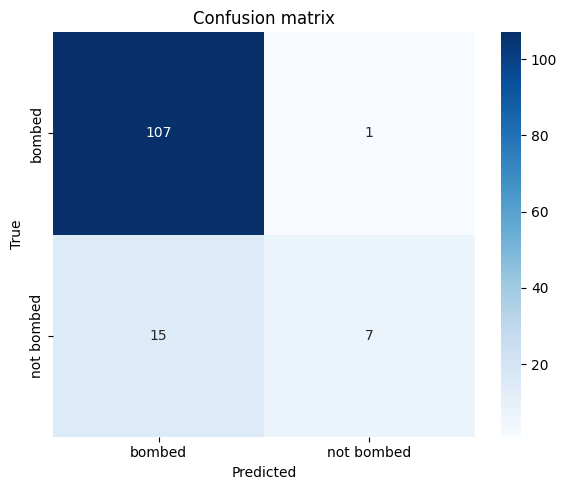

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)

print("Classification report:\n", report)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix")
plt.tight_layout()
plt.show()
